In [1]:
!pip install gast==0.2.2
!pip install tensorflow==1.15
!pip install tensorflow_hub>=0.6.0
!pip3 install tensorflow_text==1.15

  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=9651c655b165ab3899593ae8879a4594d519fb0fe4307f78d492aa2361381460
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
     |████████████████████████████████| 412.3MB 27kB/s 
     |████████████████████████████████| 51kB 5.1MB/s 
     |████████████████████████████████| 3.8MB 29.1MB/s 
     |████████████████████████████████| 512kB 34.8MB/s 
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tens

In [2]:
!pip3 install seqeval

     |████████████████████████████████| 51kB 2.7MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16172 sha256=db077d32b9156d79c5e478adb321e5debc868937a6cb96be5405a503d8175d9d
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
downloaded = drive.CreateFile({'id':"1j8_XsnH3IhqoBXGm6S9aP7Aa_D4aqXbz"})   
downloaded.GetContentFile('chap4_mahabharath_annotations.csv') 

# New section

In [6]:
import pandas as pd
annotations = pd.read_csv("chap4_mahabharath_annotations.csv", index_col=['id'])

In [7]:
annotations

,sentence#,token,tag
id,,,
0,0,Om,CONCEPT
1,0,!,O
2,1,Having,O
3,1,bowed,O
4,1,down,O
...,...,...,...
830510,34331,The,O
830511,34331,end,O
830512,34331,of,O


In [8]:
words = list(annotations['token'].values)
words.append('PADword')
n_words = len(set(words))
n_words, len(words)

(19573, 830516)

In [9]:
tags = list(set(annotations["tag"].values))
n_tags = len(tags)
print(n_tags)
tags

12


['WATER',
 'PERSON',
 'O',
 'TITLE',
 'GROUP',
 'CONCEPT',
 'BOOK',
 'WEAPON',
 'PLANT',
 'SPECIAL_OBJECT',
 'PLACE',
 'ANIMAL']

In [10]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 0
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["token"].values.tolist(),s["tag"].values.tolist())]
        self.grouped = self.data.groupby("sentence#").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None

In [11]:
getter = SentenceGetter(annotations)
sent = getter.get_next()
print(sent)

[('Om', 'CONCEPT'), ('!', 'O')]


In [12]:
sentences = getter.sentences
print(len(sentences))

34332


In [13]:
largest_sen = max(len(sen) for sen in sentences)
print('biggest sentence has {} words'.format(largest_sen))

biggest sentence has 428 words


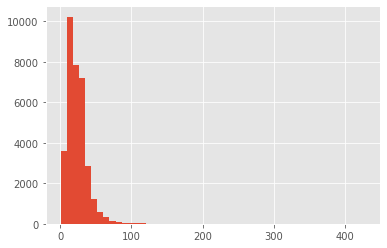

In [14]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
plt.hist([len(s) for s in sentences], bins = 50)
plt.show()

In [15]:
max_len = 50
X = [[w[0] for w in s] for s in sentences]
Y = [[w[1] for w in s] for s in sentences]
new_X = []
y_label = []
for k in range(len(X)):
    seq = X[k]
    j = 0
    while(j<len(seq)):
        new_seq = []
        new_y = []
        for i in range(j,j+max_len):
            try:
                new_seq.append(seq[i])
                new_y.append(Y[k][i])
            except:
                new_seq.append("PADword")
                new_y.append('O')
        new_X.append(new_seq)
        y_label.append(new_y)
        j=i+1

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

living_entity_tags = ['ANIMAL','PERSON','GROUP','TITLE']
non_living_entity_tags = ['BOOK','PLACE','WEAPON','SPECIAL_OBJECT','PLANT','CONCEPT','WATER']

#for extraction of entities
tags2index = {}
for tag in tags:
    if tag not in living_entity_tags and tag not in non_living_entity_tags:
        tags2index[tag] = 0
    elif tag in living_entity_tags:
        tags2index[tag] = 1
    else:
        tags2index[tag] = 2
        
# tags2index = {t:i for i,t in enumerate(tags)}
y=[]        
for labels in y_label:
    word_tag = []
    for label in labels:
#         print(label)
        word_tag.append(tags2index[label])
    y.append(np.array(word_tag))
tags2index

{'ANIMAL': 1,
 'BOOK': 2,
 'CONCEPT': 2,
 'GROUP': 1,
 'O': 0,
 'PERSON': 1,
 'PLACE': 2,
 'PLANT': 2,
 'SPECIAL_OBJECT': 2,
 'TITLE': 1,
 'WATER': 2,
 'WEAPON': 2}

In [17]:
y = np.array(y)

In [18]:
y[0], new_X[0]

(array([2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]),
 ['Om',
  '!',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword'])

In [19]:
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import add, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda
import seqeval
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

batch_size = 32
def ElmoEmbedding(x):
    return elmo_model(inputs={"tokens": tf.squeeze(tf.cast(x,tf.string)),
                              "sequence_len": tf.constant(batch_size*[max_len])},
                      signature="tokens",
                      as_dict=True)["elmo"]

X_tr, X_te, y_tr, y_te = train_test_split(new_X, y, test_size=0.1, random_state=2021)

In [20]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import backend as K

sess = tf.compat.v1.Session()
K.set_session(sess)
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [21]:
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import add
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda



input_text = Input(shape=(max_len,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2) )(x)
x = add([x, x_rnn])  
# out = TimeDistributed(Dense(12, activation="softmax"))(x)
out = TimeDistributed(Dense(3, activation="softmax"))(x)
model = Model(input_text, out)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [22]:
len(X_tr), len(X_te), batch_size,len(X_tr)/batch_size, len(X_te)/batch_size 

(32470, 3608, 32, 1014.6875, 112.75)

In [23]:
X_tr, X_val = X_tr[:914*batch_size], X_tr[-100*batch_size:]
y_tr, y_val = y_tr[:914*batch_size], y_tr[-100*batch_size:]
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

In [24]:
history = model.fit(np.array(X_tr), y_tr, validation_data=(np.array(X_val), y_val),batch_size=batch_size, epochs=3, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 29248 samples, validate on 3200 samples
Epoch 1/3
29248/29248 [==============================] - 1125s 38ms/sample - loss: 0.0095 - acc: 0.9966 - val_loss: 0.0035 - val_acc: 0.9989
Epoch 2/3
29248/29248 [==============================] - 1119s 38ms/sample - loss: 0.0035 - acc: 0.9988 - val_loss: 0.0044 - val_acc: 0.9985
Epoch 3/3
29248/29248 [==============================] - 1117s 38ms/sample - loss: 0.0024 - acc: 0.9992 - val_loss: 0.0029 - val_acc: 0.9990


In [25]:
X_te = X_te[:112*batch_size]
y_te = y_te[:112*batch_size]
preds = model.predict(np.array(X_te), verbose=1, batch_size=batch_size)

3584/3584 [==============================] - 86s 24ms/sample


In [26]:
# in case of classification
# idx2tag = {i: w for w, i in tags2index.items()}

# in case of extraction of entities
idx2tag = {}
for k,v in tags2index.items():
    if v == 0:
        idx2tag[v] = 'O'
    elif v == 1:
        idx2tag[v] = "LIVING"
    else:
      idx2tag[v] = "NON-LIVING"
        
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PADword", "O"))
        out.append(out_i)
    return out

In [27]:
pred_labels = pred2label(preds)

In [28]:
test_labels = test2label(y_te)

In [29]:
print(classification_report(pred_labels, test_labels))

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: LIVING seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NON-LIVING seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


              precision    recall  f1-score   support

       IVING       0.99      0.96      0.98      3955
      LIVING       0.76      0.86      0.81       545

   micro avg       0.96      0.95      0.95      4500
   macro avg       0.87      0.91      0.89      4500
weighted avg       0.96      0.95      0.96      4500

